<a href="https://colab.research.google.com/github/arao53/cee243_s23/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

## Define model and inputs

In [81]:
## define all given parameters in a dictionary
params = {"p0"        : 100,
          "b0"        : 500,
          "c0"        : 25000,
          "s0"        : 5000,
          "ds_plus"   : 0.3,
          "ds_minus"  : 0.1,
          "dc_minus"  : 0.2,
          "db_plus"   : 0.1,
          "db_minus"  : 0.05,
          "pI0"       : 1.2,
          "alpha_p"   : 2500,
          "l"         : 2.,
          "U0"        : 0.,
          "D0"        : 0.,
          "Ec0"       : 100,
          "Es0"       : 500,
          "R0"        : 1500,
          "N0"        : 0.,     # Initial rate of pollution decay
          "T"         : 100,    # Number of time steps
          }


In [82]:
# create simulation class

class SystemSimulator():
  def __init__(self, params, prints=False):
    self.prints = prints
    if self.prints is True: print(">>> Unpacking parameter dictionary")
    for key in params:
      setattr(self, key, float(params[key]))
    self.T = int(self.T)
    
    if prints is True: print(">>> Initializing stocks and flows")

    # create arrays to store data in the simulation
      # define stocks and flows at each time step
    self.p = np.zeros(self.T)     # pollution stock
    self.b = np.zeros(self.T)     # building stock
    self.c = np.zeros(self.T)     # coal stock
    self.s = np.zeros(self.T)     # solar stock
    self.U = np.zeros(self.T)     # urban growth (flow)
    self.D = np.zeros(self.T)     # Decomissioned buildings (flow)
    self.pI = np.zeros(self.T)    # Pollution intensity (flow)
    self.Ec = np.zeros(self.T)    # Coal consumption 
    self.Es = np.zeros(self.T)    # Solar consumption
    self.N = np.zeros(self.T)     # Pollution decay
    self.R = np.zeros(self.T)     # Solar inflow

    # set initial values
    self.p[0] = self.p0
    self.b[0] = self.b0
    self.c[0] = self.c0
    self.s[0] = self.s0
    self.U[0] = self.U0
    self.D[0] = self.D0
    self.pI[0] = self.pI0
    self.Ec[0] = self.Ec0
    self.Es[0] = self.Es0
    self.N[0] = self.N0
    self.R[0] = self.R0

  def simulate(self):
    if self.prints is True: print(">>> Simulating system...")
    for t in range(1,self.T):
      # update stocks
        # pollution
      self.p[t] = self.update_pollution_stock(p = self.p[t-1],
                                              Ec = self.Ec[t-1],
                                              pI = self.pI[t-1],
                                              N = self.N[t-1])
        # buildings
      self.b[t] = self.update_building_stock(b = self.b[t-1],
                                             U = self.U[t-1], 
                                             D = self.D[t-1])
        # coal
      self.c[t] = self.update_coal_stock(c = self.c[t-1],
                                         Ec = self.Ec[t-1])
        # solar
      self.s[t] = self.update_solar_stock(s = self.s[t-1],
                                          Es = self.Es[t-1],
                                          R = self.R[t-1])
      
      # update flows
      self.U[t] = self.update_urban_growth(p = self.p[t], b = self.b[t])

      self.D[t] = self.update_decomission_rate(b = self.b[t])

      self.pI[t] = self.update_pollution_intensity(pIt1 = self.pI[t-1],
                                                   ct = self.c[t], 
                                                   ct1 = self.c[t-1])
      
      self.Ec[t], self.Es[t] = self.update_energy_consumption(bt = self.b[t],
                                                              bt1 = self.b[t-1],
                                                              ct = self.c[t],
                                                              st = self.s[t],
                                                              Ec1 = self.Ec[t-1],
                                                              Es1 = self.Es[t-1])
      self.N[t] = self.update_pollution_decay(p = self.p[t])

      self.R[t] = self.update_solar_inflow(bt = self.b[t],
                                           bt1 = self.b[t-1],
                                           Rt1 = self.R[t-1])
    if self.prints is True: print(">>> Simulation complete")

      
  def update_building_stock(self,b, U, D):
      """
      b: Existing building stock
      U: Urban growth (number of new buildings)
      D: Decomissioning (number of removed buildings)
      return: b[t]
      """
      return b + U - D

  def update_pollution_stock(self, p, Ec, pI, N):
      """
      p: Existing pollution stock
      Ec: Coal consumption
      pI: Pollution intensity of coal consumption
      N: Pollution decay
      """
      return p + Ec*pI - N

  def update_coal_stock(self, c, Ec):
      """
      c: Existing coal stock
      Ec: Coal consumption
      """
      return c - Ec
    
  def update_solar_stock(self, s, Es, R):
      """
      s: Existing solar stock
      Es: Solar consumption
      R: Solar inflows
      """
      return s - Es + R

  def update_urban_growth(self, p, b):
      """
      p: Existing pollution stock
      """
      if p > self.alpha_p:
        return 0
      else:
        return self.db_plus * b

  def update_decomission_rate(self, b):
      """
      b: Existing building stock
      """
      return self.db_minus * b
  
  def update_pollution_intensity(self, pIt1, ct, ct1):
      """
      pIt1: Existing pollution intensity
      ct: Existing coal stock
      ct1: Previous coal stock
      """
      return pIt1 ** (1+ np.abs(ct - ct1)/self.c0)

  def update_energy_consumption(self, bt, bt1, ct, st, Ec1, Es1):
      """
      bt: Existing building stock
      bt1: Previous building stock
      ct: Existing coal stock
      Ec1: Previous coal consumption
      Es1: Previous energy consumption
      """
      # expected amount of coal consumption
      Ec = Ec1 + self.dc_minus * (bt - bt1)
      # expected amount of solar consumption
      Es = Es1 + self.ds_minus * (bt - bt1)

      # check if there is enough coal stock
      if ct < Ec:
        # if not, convert the remaining energy to solar with a 2x penalty
        Es = Es + 2*(Ec - ct)
        # consume the rest of the available coal stock
        Ec = ct
      if st < Es:
        residual = Es - st
        Es = st
        # warnings.warn("Warning: Not enough energy available. Residual = "+ str(round(residual)) + " units.", stacklevel=2);
      return Ec, Es

  def update_pollution_decay(self, p):
      """
      p: Existing pollution stock
      """
      return p * np.exp(-self.l)

  def update_solar_inflow(self, bt, bt1, Rt1):
      """
      bt: Existing building stock
      bt1: Previous building stock
      Rt1: Previous solar inflow
      """
      if bt < 3*self.b0:
        return Rt1 + self.ds_plus * (bt - bt1)
      else:  
        return Rt1 * (1 - (bt - 3*self.b0)/(3*self.b0))

  def save_results(self,):
      """
      Returns:
            df: dataframe containing all save_list variables.
      """
      # If save_list is none, default returns all stocks and flows
      save_list = ['p', 'b', 'c', 's', 'U', 'D', 'pI', 'Ec', 'Es', 'N', 'R']

      self.df = pd.DataFrame()

      for item in save_list:
        vals = getattr(self, item)
        self.df[item] = vals
      return self.df

def plot_stocks(df,ax):
    #fig, ax = plt.subplots(2,2)
    ax[0,0].plot(df.p)
    ax[0,0].set_ylabel("Pollution stock")

    ax[0,1].plot(df.b)
    ax[0,1].set_ylabel("Building stock")

    ax[1,0].plot(df.c)
    ax[1,0].set_ylabel("Coal stock")

    ax[1,1].plot(df.s)
    ax[1,1].set_ylabel("Solar stock")

    for a in ax.flat: a.set_xlabel("Time [yr]")

    fig.suptitle("System Stocks")
    fig.tight_layout()
    
    return fig, ax
    
def plot_inflows(df,ax):
    #fig, ax = plt.subplots(3, 1)
    ax[0].plot(df.pI)
    ax[0].set_ylabel("Pollution Intensity")
    
    ax[1].plot(df.R)
    ax[1].set_ylabel("Solar Inflow")
    
    ax[2].plot(df.U)
    ax[2].set_ylabel("Urban Growth")

    for a in ax.flat: a.set_xlabel("Time [yr]")

    fig.suptitle("System Inflows")
    fig.tight_layout()

    return fig, ax

def plot_outflows(df,ax):
    #fig, ax = plt.subplots(2,2)
    ax[0,0].plot(df.Ec)
    ax[0,0].set_ylabel("Consumption of Coal")
    
    ax[0,1].plot(df.Es)
    ax[0,1].set_ylabel("Consumption of Solar")
    
    ax[1,0].plot(df.N)
    ax[1,0].set_ylabel("Pollution Decay")

    ax[1,1].plot(df.D)
    ax[1,1].set_ylabel("Decomission Rate")

    for a in ax.flat: a.set_xlabel("Time [yr]")

    fig.suptitle("System Outflows")
    fig.tight_layout()

    return fig, ax

## Baseline Simulation

In [83]:
model = SystemSimulator(params, prints=True)
model.simulate()
df = model.save_results()

>>> Unpacking parameter dictionary
>>> Initializing stocks and flows
>>> Simulating system...
>>> Simulation complete


In [152]:
over_pollution = np.where((df.p.values) >= model.alpha_p, 1, np.nan)
grad_pI = np.mean(np.gradient(model.pI))
grad_c = -np.mean(np.gradient(model.c))
solar_ratio = np.sum(model.Es) / np.sum(model.Ec)

<ipython-input-82-1926f240d809>:214: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


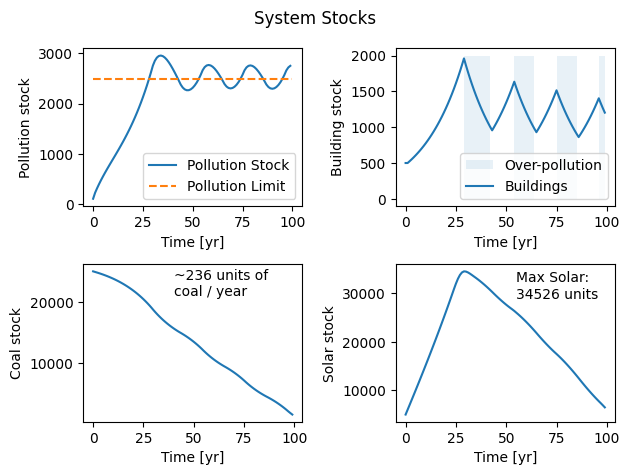

In [154]:
fig, ax = plt.subplots(2,2, constrained_layout=True)
ax[0,1].fill_between(range(model.T), over_pollution, 2000*over_pollution, alpha =0.1)
fig, ax = plot_stocks(df,ax)
ax[0,0].plot(np.array([0,100]), np.ones(2) * model.alpha_p, '--')
ax[0,0].legend(["Pollution Stock", "Pollution Limit"])
ax[0,1].legend(["Over-pollution", "Buildings"])

ax[1,0].text(40, 21000,"~{} units of \ncoal / year".format(round(grad_c)))

ax[1,1].text(55, 29000, "Max Solar: \n{} units".format(round(max(df.s))))
fig.tight_layout()


Text(97, 150, '3')

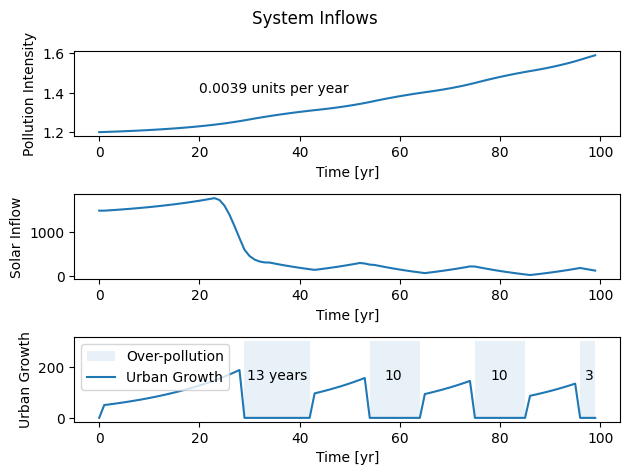

In [148]:
fig, ax = plt.subplots(3,1)
ax[2].fill_between(range(model.T), over_pollution, 300*over_pollution, alpha =0.1)
fig, ax = plot_inflows(df,ax)

ax[0].text(20, 1.4,"{} units per year".format(round(grad_pI, 4)))


ax[2].legend(["Over-pollution", "Urban Growth"], loc = "upper left")
ax[2].text(29.5, 150, "13 years")
ax[2].text(57, 150, "10")
ax[2].text(78, 150, "10")
ax[2].text(97, 150, "3")

Text(20, 510, 'Solar Consumption was \n~2.4x Coal consumption')

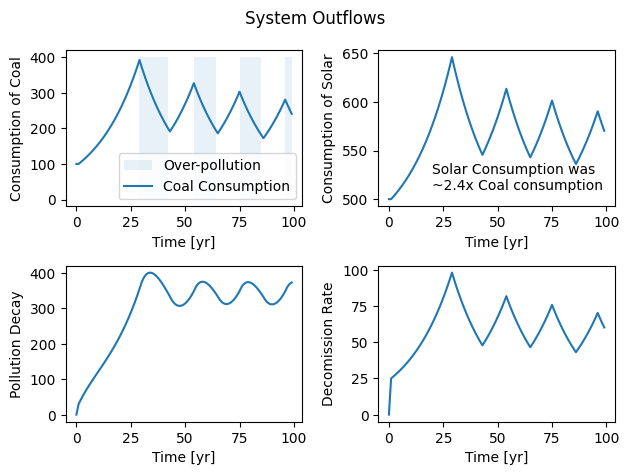

In [147]:
fig, ax = plt.subplots(2,2)
ax[0,0].fill_between(range(model.T), over_pollution, 400*over_pollution, alpha =0.1)
fig, ax = plot_outflows(df,ax)
ax[0,0].legend(["Over-pollution", "Coal Consumption"])
ax[0,1].text(20, 510,"Solar Consumption was \n~{}x Coal consumption".format(round(solar_ratio,1)))


## Sensitivity Analysis

**Note: There are some issues with formatting in the PDF version. Please check the notebook file to view all sensitivity plots.**

In [8]:
def sensitivity_analysis(plot_type):
  for key, value in params.items():
    if plot_type == 'stock':
      fig, ax = plt.subplots(2,2, constrained_layout=True)
      fig.suptitle("System Stocks: varying "+key)
    elif plot_type == 'outflow':
      fig, ax = plt.subplots(2,2, constrained_layout=True)
      fig.suptitle("System Outflows: varying "+key)
    elif plot_type == 'inflow':
      fig, ax = plt.subplots(3,1, constrained_layout=True)
      fig.suptitle("System Inflows: varying "+key)
    
    params_copy = params.copy()
    scaling_factors = [1,1.5,0.5]
    params_list = [value*i for i in scaling_factors]
    dfs = [None] * len(params_list)

    for i, p in enumerate(params_list):
      params_copy[key] = p
      print(key,params_copy[key])
      model = SystemSimulator(params_copy, prints = False)
      model.simulate()
      tmp_results = model.save_results()

      if plot_type == 'stock':
        fig, ax = plot_stocks(tmp_results,ax)
      elif plot_type == 'inflow':
        fig, ax = plot_inflows(tmp_results,ax)
      elif plot_type == 'outflow':
        fig, ax = plot_outflows(tmp_results,ax)
    
    plt.figlegend(['original','+50%','-50%'])     

p0 100
p0 150.0
p0 50.0
b0 500
b0 750.0
b0 250.0
c0 25000
c0 37500.0
c0 12500.0
s0 5000
s0 7500.0
s0 2500.0
ds_plus 0.3
ds_plus 0.44999999999999996
ds_plus 0.15
ds_minus 0.1
ds_minus 0.15000000000000002
ds_minus 0.05
dc_minus 0.2
dc_minus 0.30000000000000004
dc_minus 0.1
db_plus 0.1
db_plus 0.15000000000000002
db_plus 0.05
db_minus 0.05
db_minus 0.07500000000000001
db_minus 0.025
pI0 1.2
pI0 1.7999999999999998
pI0 0.6
alpha_p 2500
alpha_p 3750.0
alpha_p 1250.0
l 2.0
l 3.0
l 1.0
U0 0.0
U0 0.0
U0 0.0
D0 0.0
D0 0.0
D0 0.0
Ec0 100
Ec0 150.0
Ec0 50.0
Es0 500
Es0 750.0
Es0 250.0
R0 1500
R0 2250.0
R0 750.0
N0 0.0
N0 0.0
N0 0.0
T 100
T 150.0
T 50.0


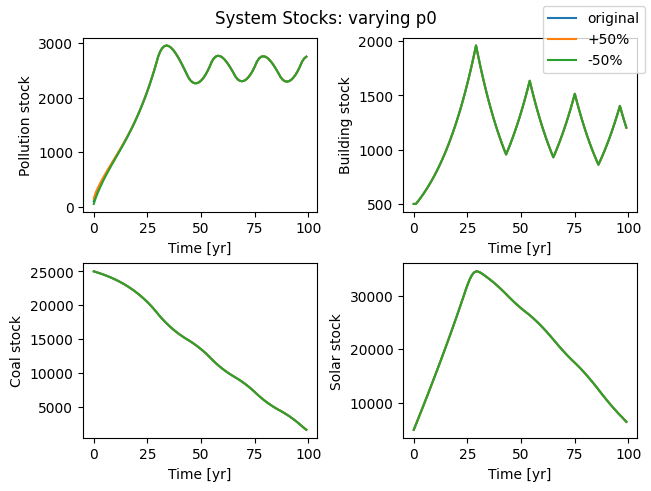

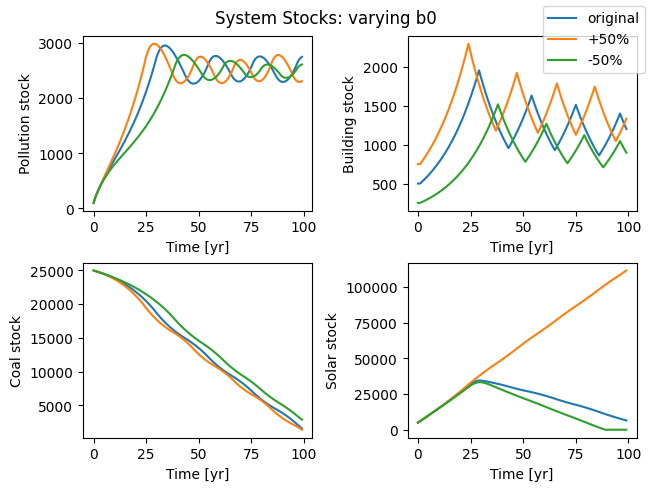

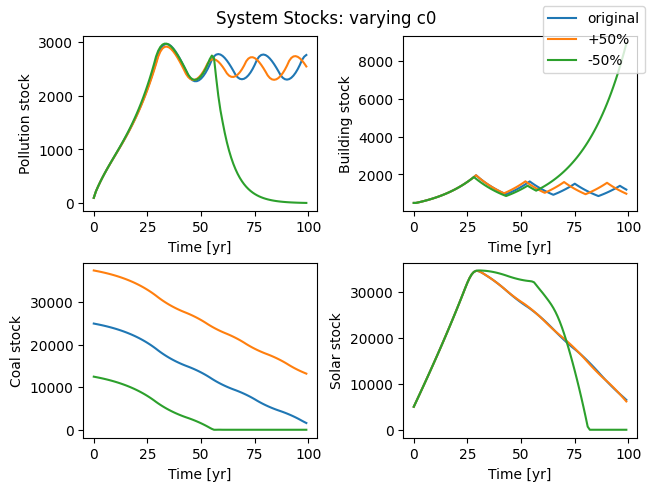

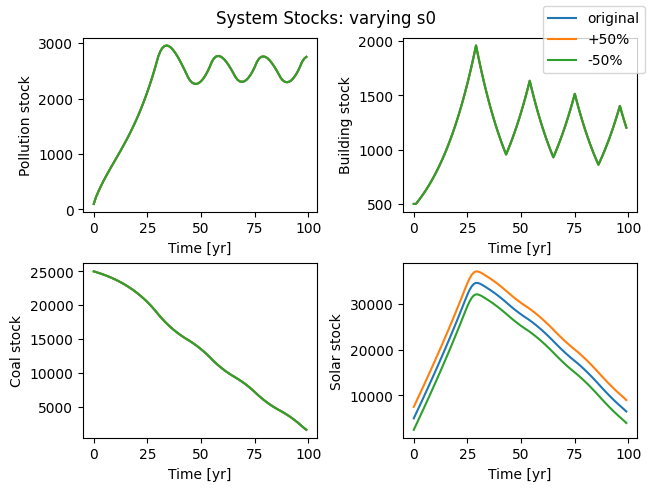

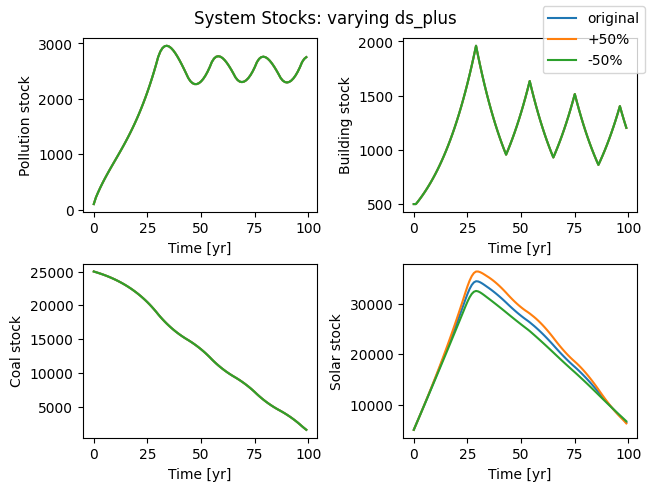

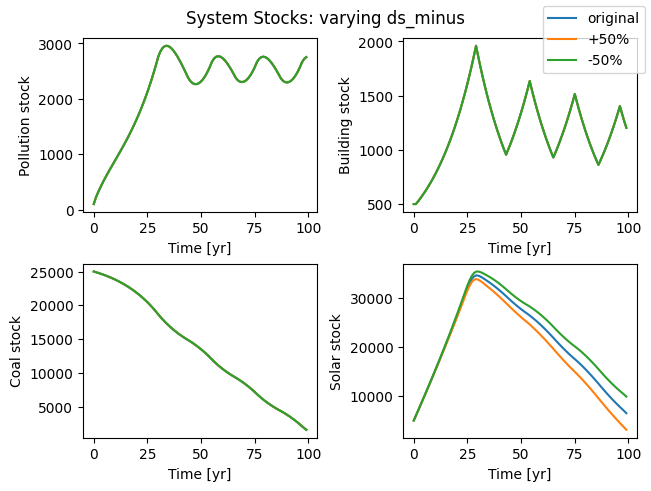

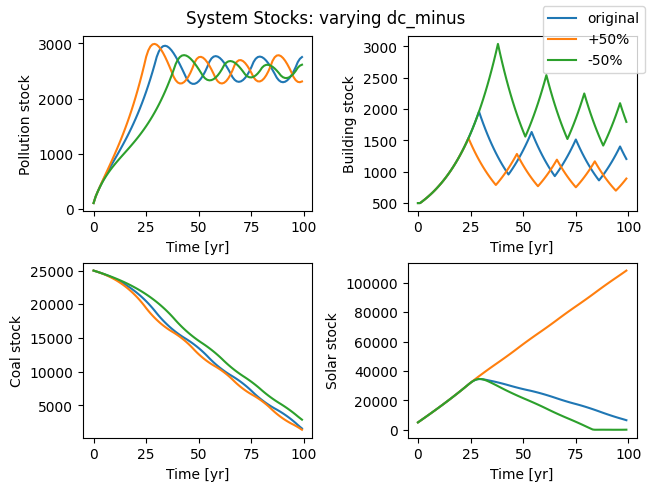

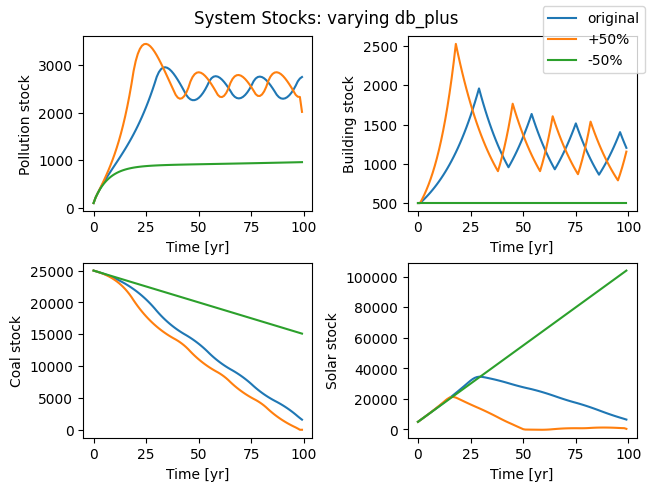

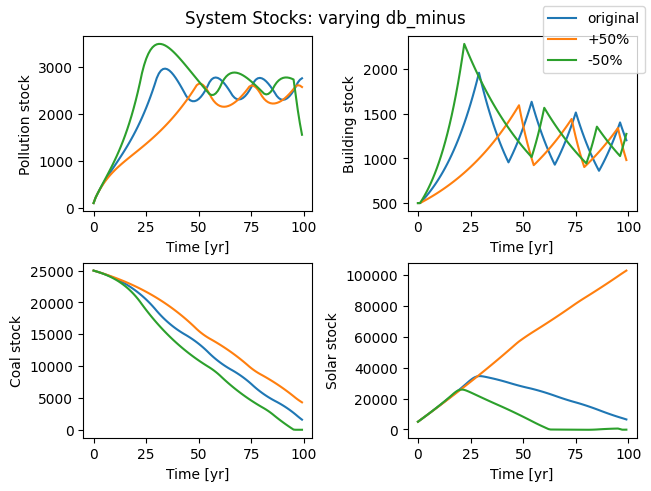

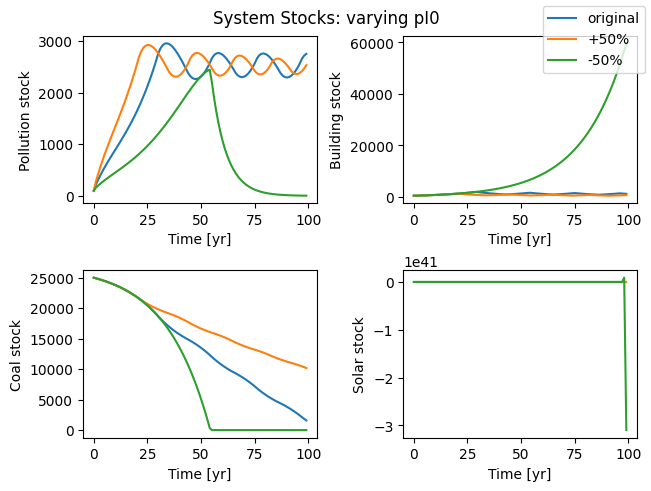

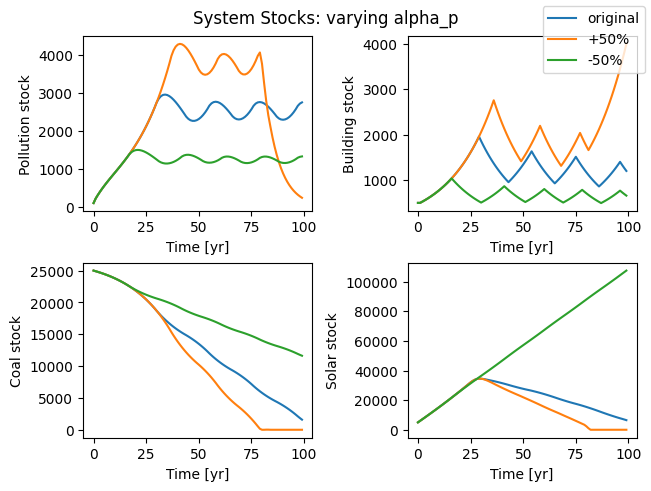

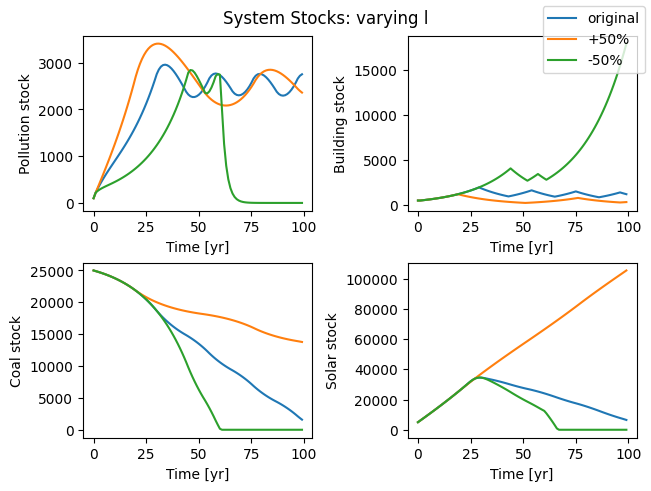

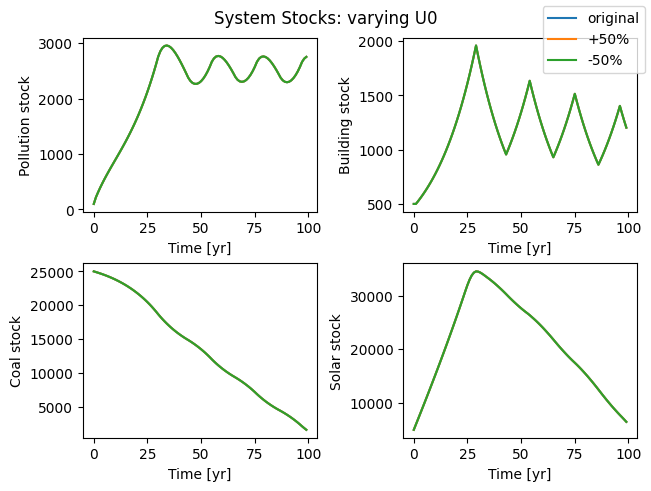

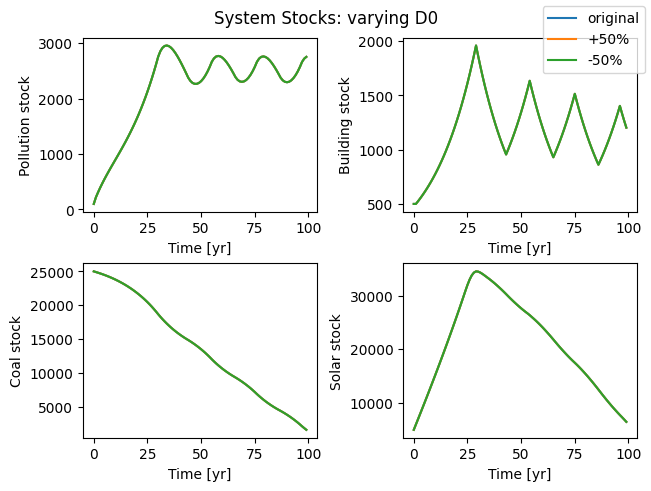

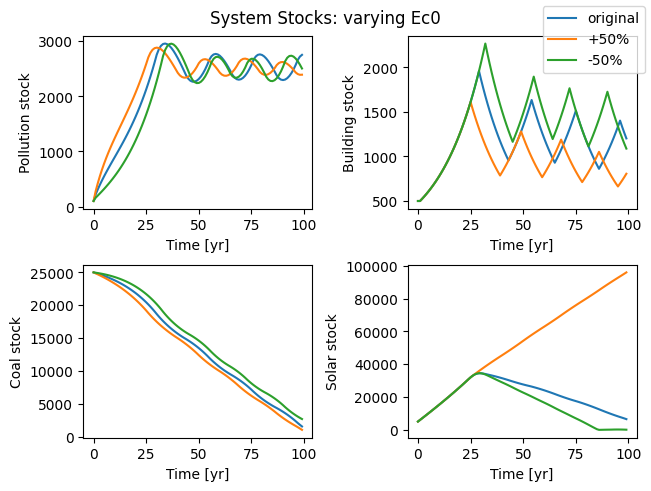

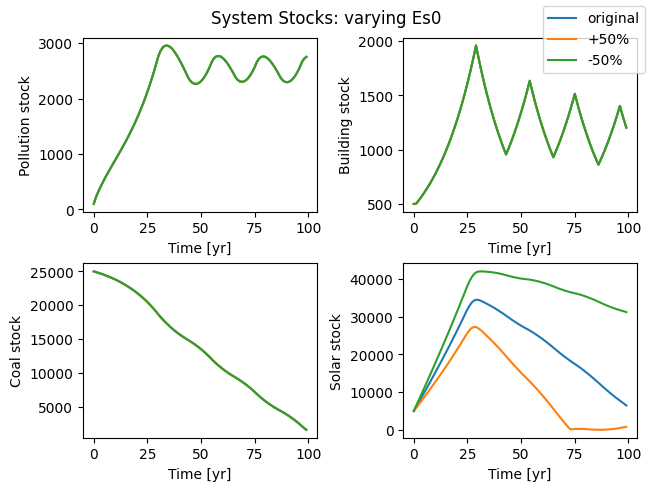

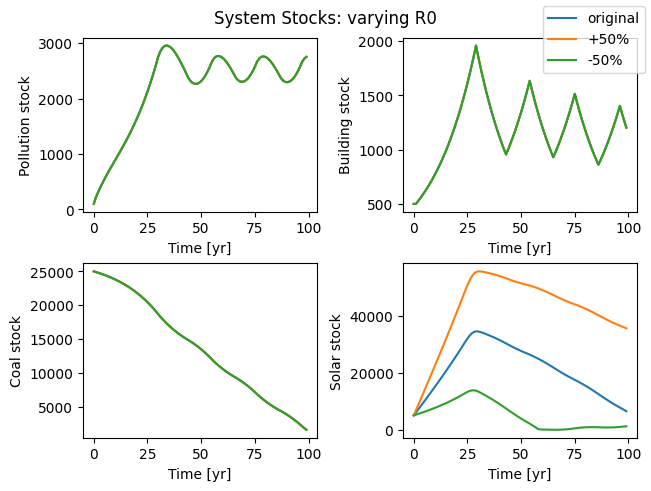

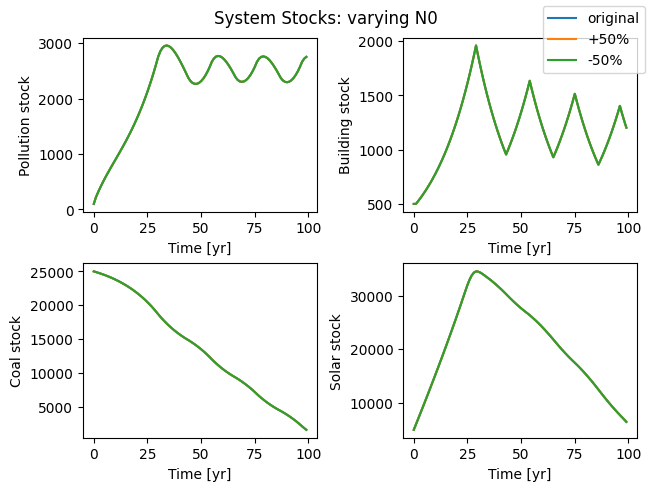

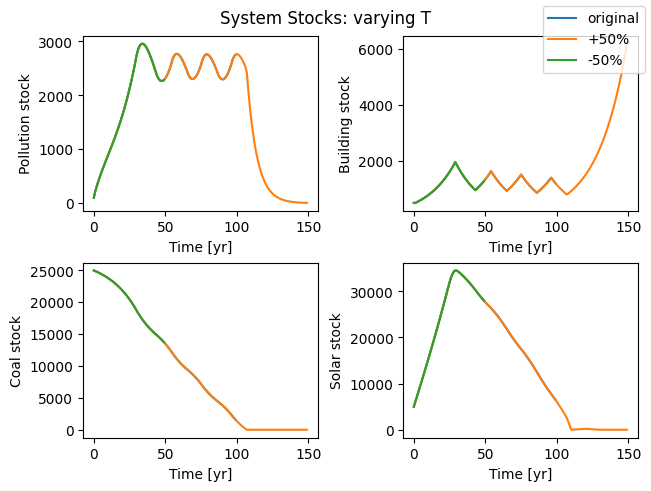

In [9]:
# run sensitivity analysis for stocks
sensitivity_analysis('stock')

p0 100
p0 150.0
p0 50.0
b0 500
b0 750.0
b0 250.0
c0 25000
c0 37500.0
c0 12500.0
s0 5000
s0 7500.0
s0 2500.0
ds_plus 0.3
ds_plus 0.44999999999999996
ds_plus 0.15
ds_minus 0.1
ds_minus 0.15000000000000002
ds_minus 0.05
dc_minus 0.2
dc_minus 0.30000000000000004
dc_minus 0.1
db_plus 0.1
db_plus 0.15000000000000002
db_plus 0.05
db_minus 0.05
db_minus 0.07500000000000001
db_minus 0.025
pI0 1.2
pI0 1.7999999999999998
pI0 0.6
alpha_p 2500
alpha_p 3750.0
alpha_p 1250.0
l 2.0
l 3.0
l 1.0
U0 0.0
U0 0.0
U0 0.0
D0 0.0
D0 0.0
D0 0.0
Ec0 100
Ec0 150.0
Ec0 50.0
Es0 500
Es0 750.0
Es0 250.0
R0 1500
R0 2250.0
R0 750.0
N0 0.0
N0 0.0
N0 0.0
T 100
T 150.0
T 50.0


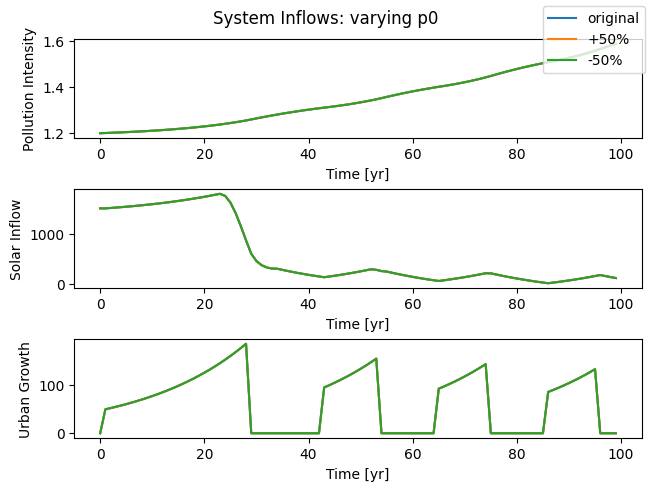

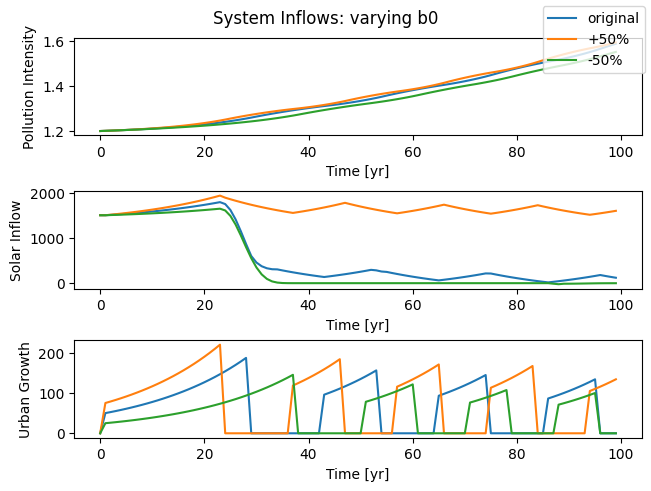

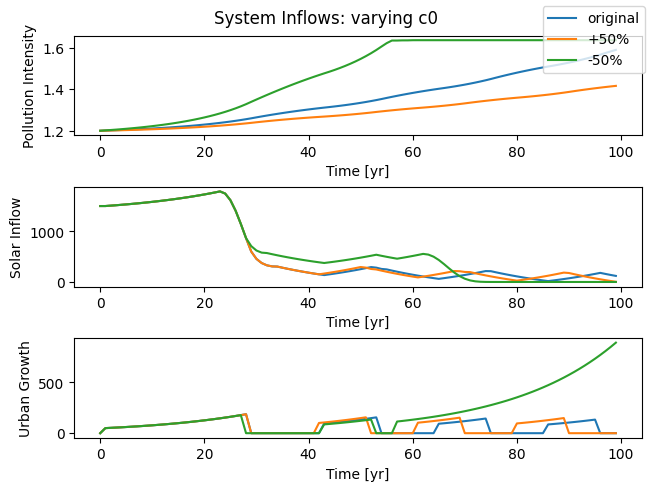

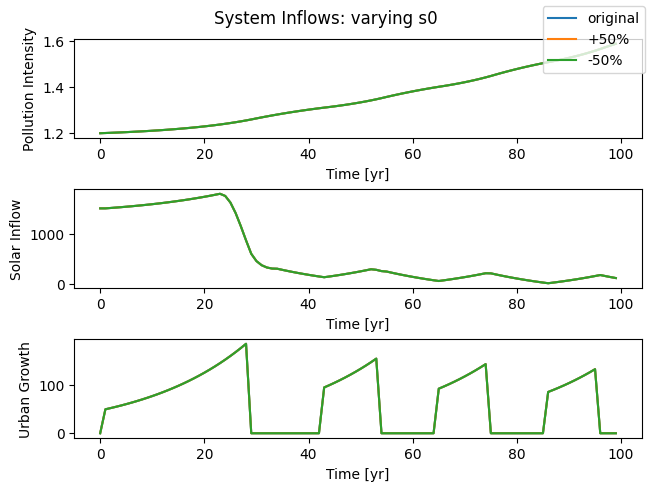

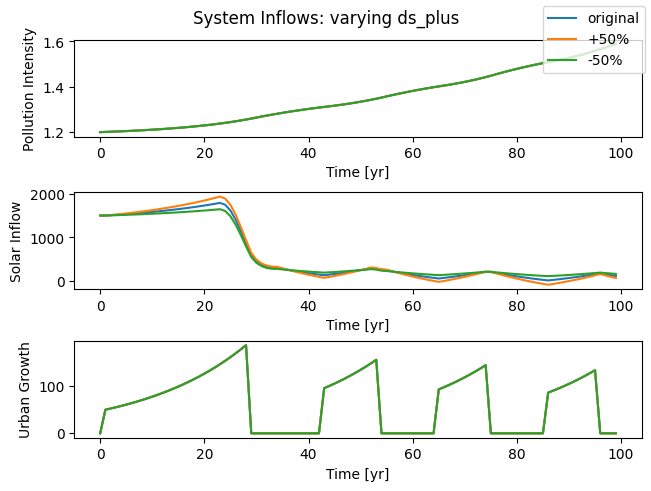

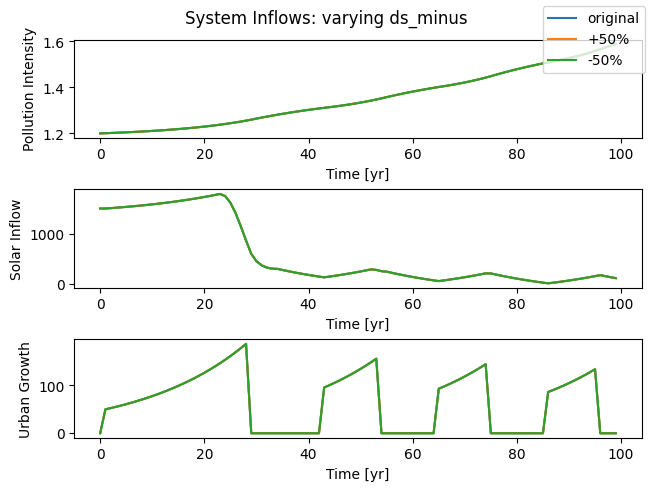

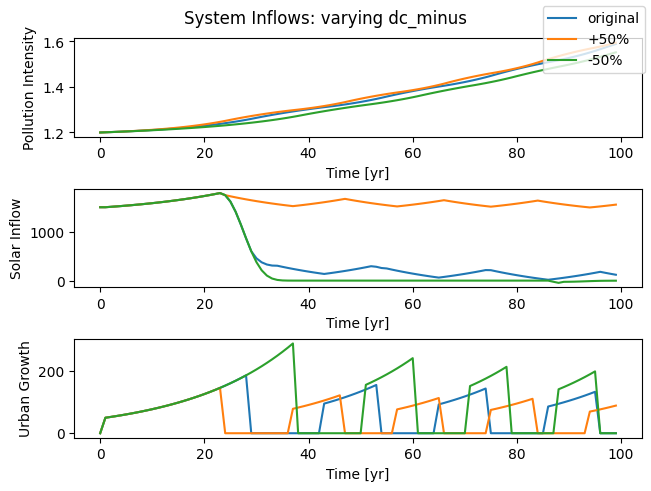

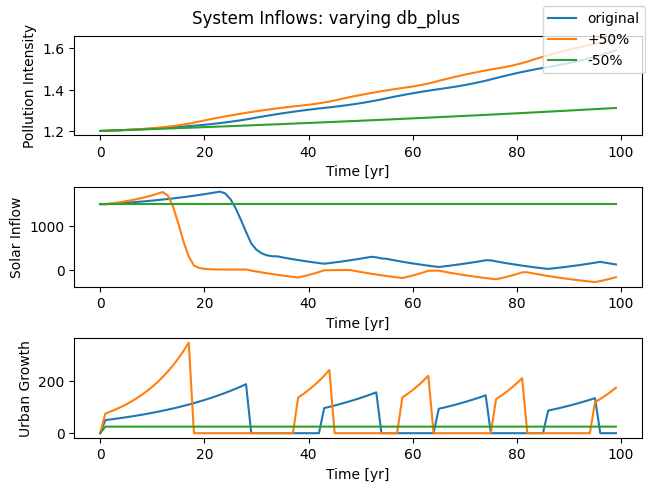

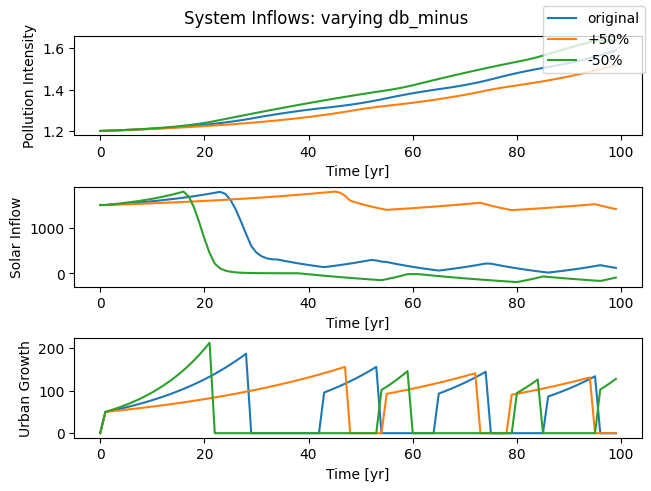

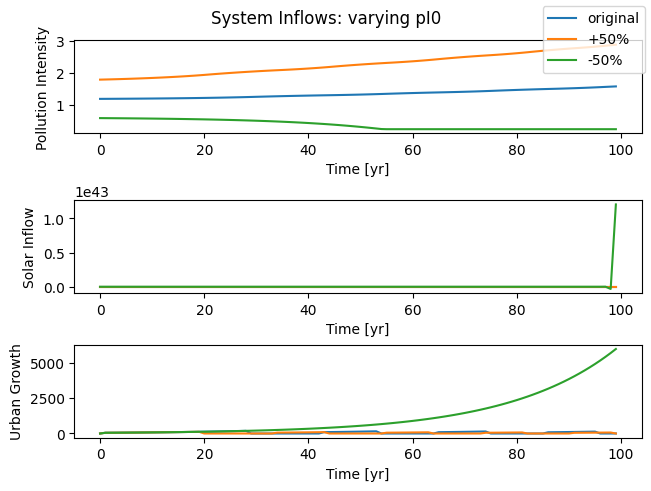

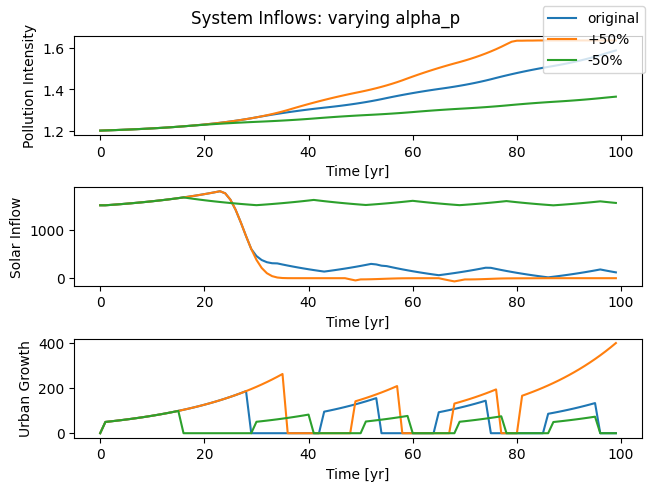

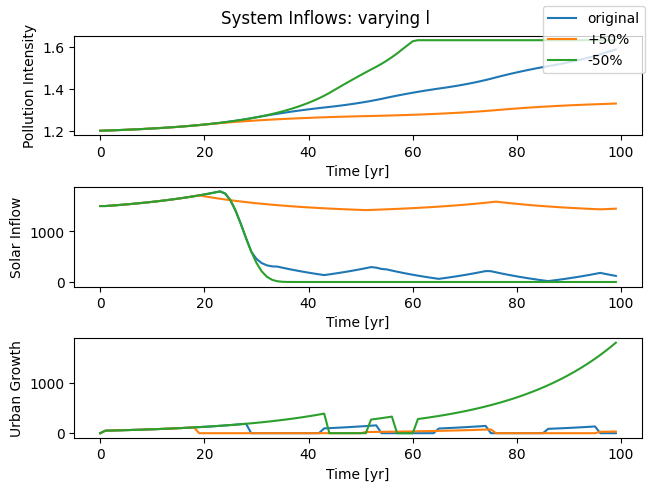

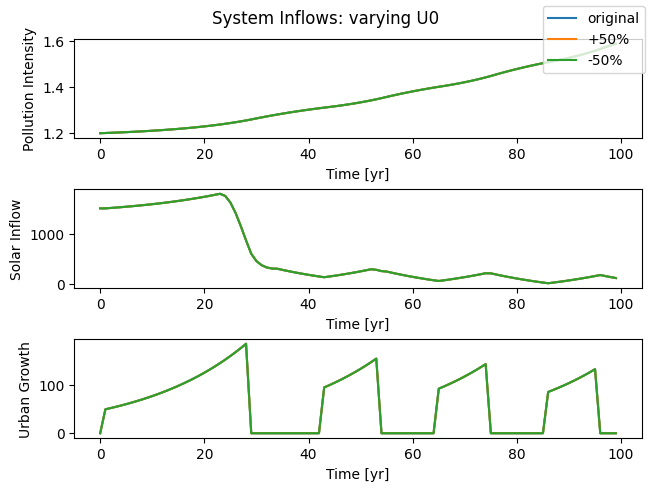

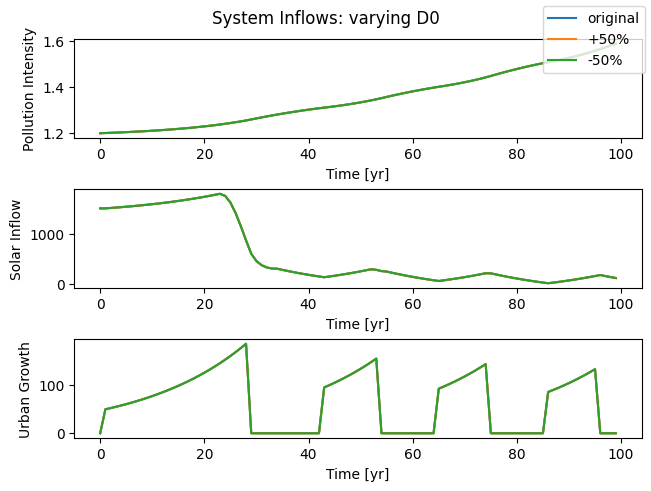

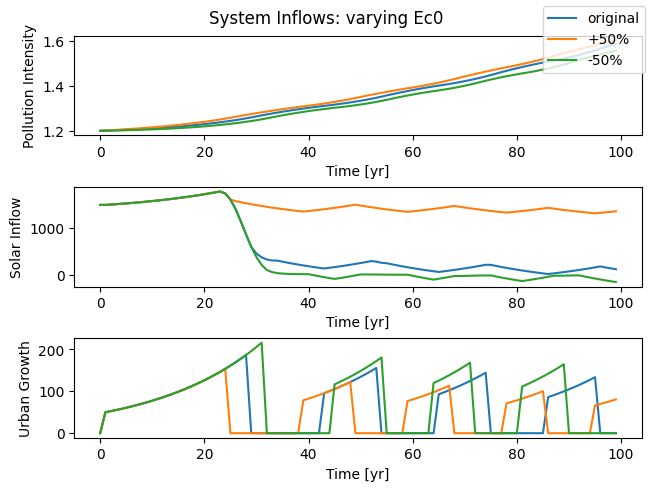

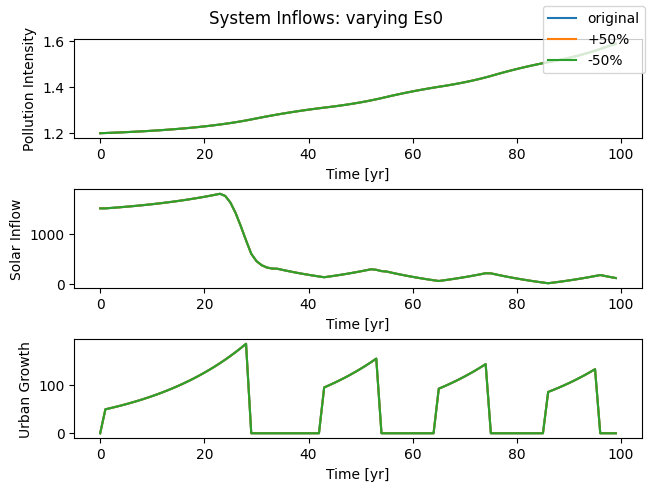

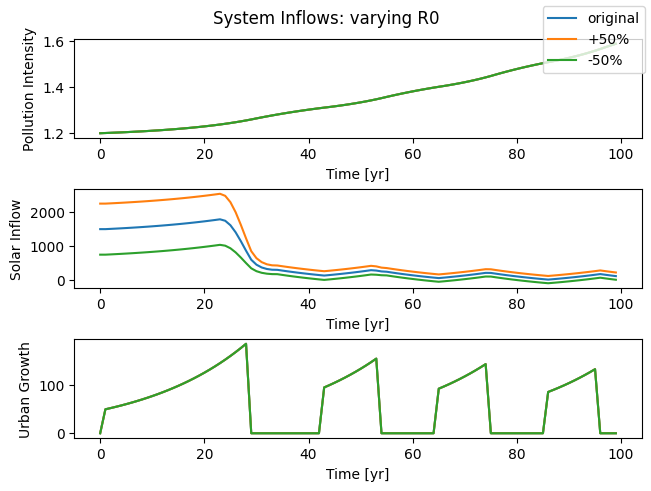

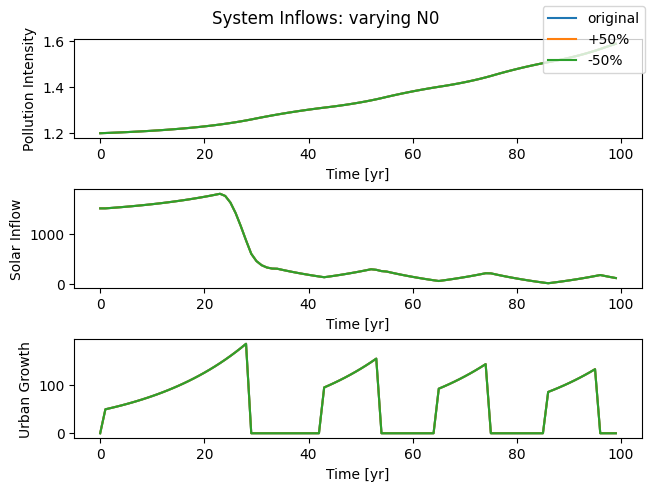

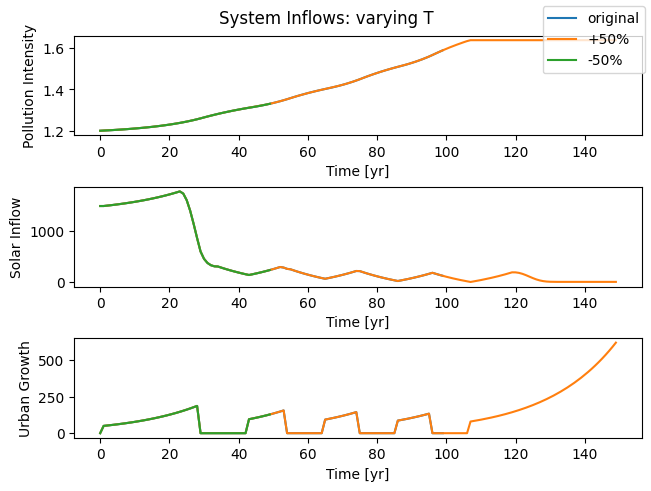

In [10]:
# run sensitivity analysis for inflows
sensitivity_analysis('inflow')

p0 100
p0 150.0
p0 50.0
b0 500
b0 750.0
b0 250.0
c0 25000
c0 37500.0
c0 12500.0
s0 5000
s0 7500.0
s0 2500.0
ds_plus 0.3
ds_plus 0.44999999999999996
ds_plus 0.15
ds_minus 0.1
ds_minus 0.15000000000000002
ds_minus 0.05
dc_minus 0.2
dc_minus 0.30000000000000004
dc_minus 0.1
db_plus 0.1
db_plus 0.15000000000000002
db_plus 0.05
db_minus 0.05
db_minus 0.07500000000000001
db_minus 0.025
pI0 1.2
pI0 1.7999999999999998
pI0 0.6
alpha_p 2500
alpha_p 3750.0
alpha_p 1250.0
l 2.0
l 3.0
l 1.0
U0 0.0
U0 0.0
U0 0.0
D0 0.0
D0 0.0
D0 0.0
Ec0 100
Ec0 150.0
Ec0 50.0
Es0 500
Es0 750.0
Es0 250.0
R0 1500
R0 2250.0
R0 750.0
N0 0.0
N0 0.0
N0 0.0
T 100
T 150.0
T 50.0


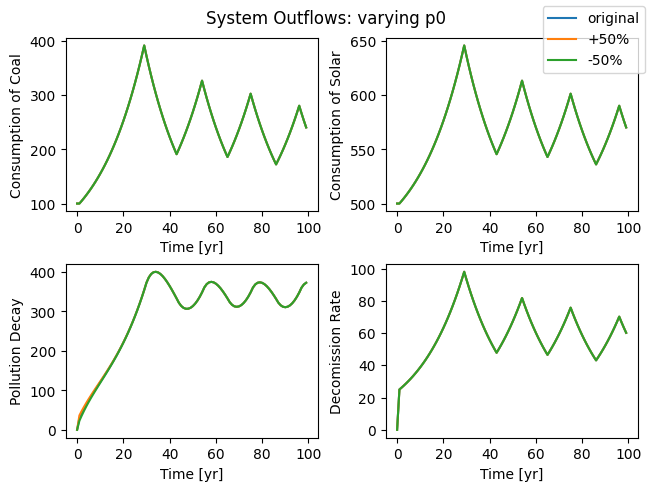

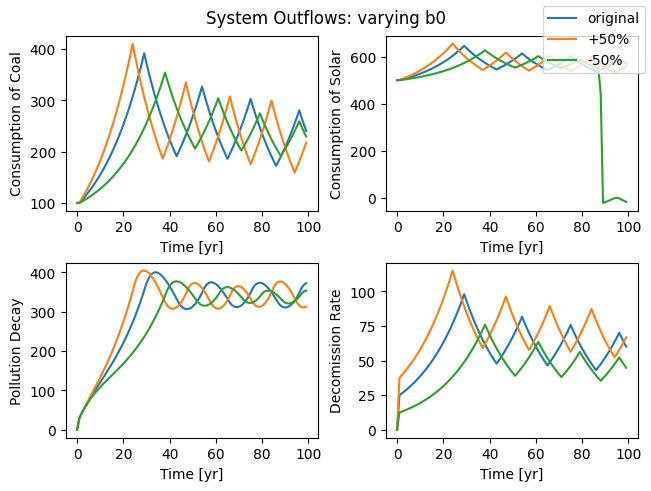

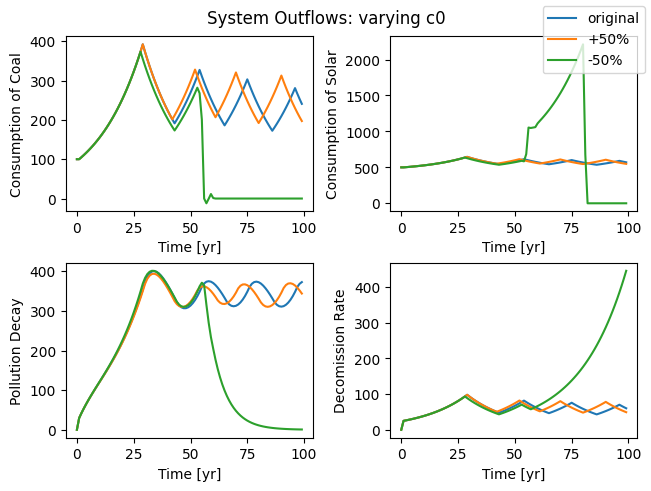

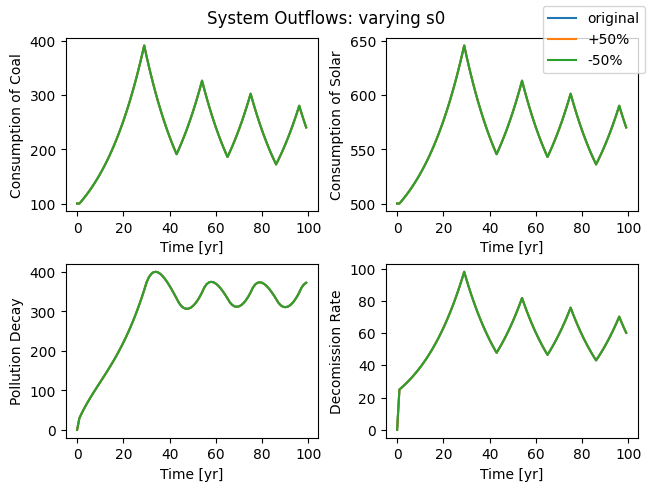

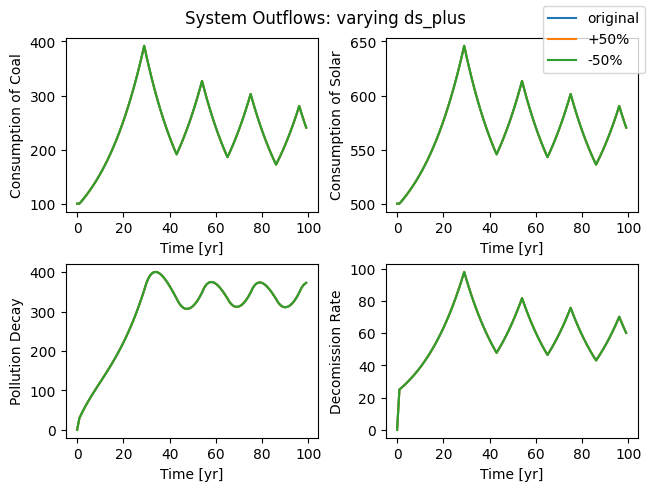

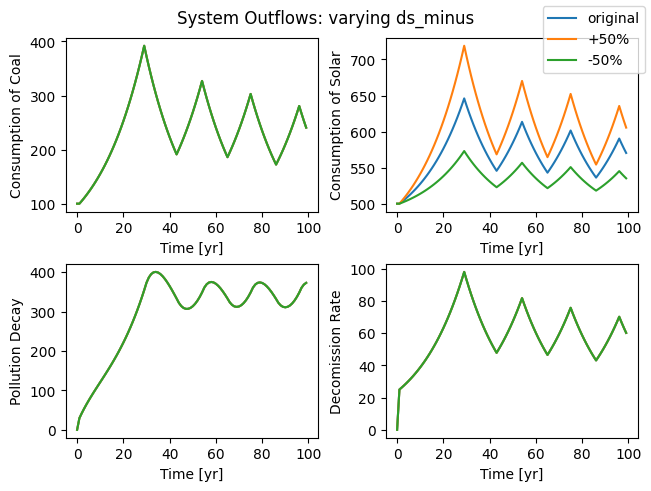

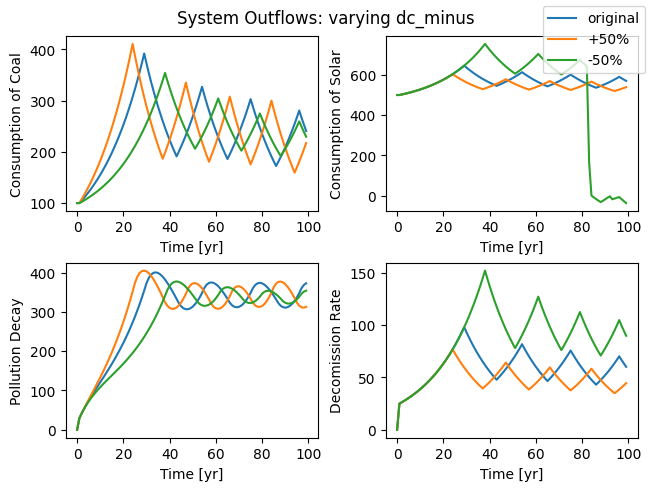

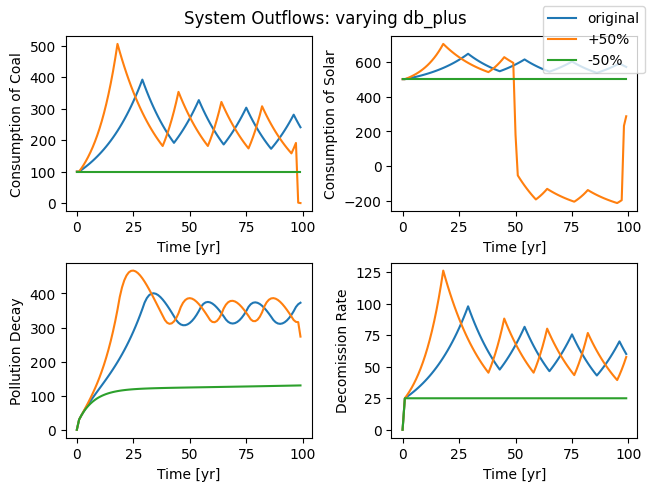

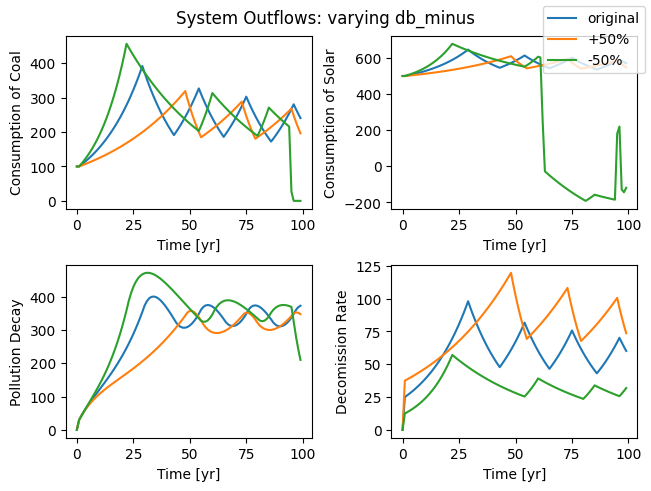

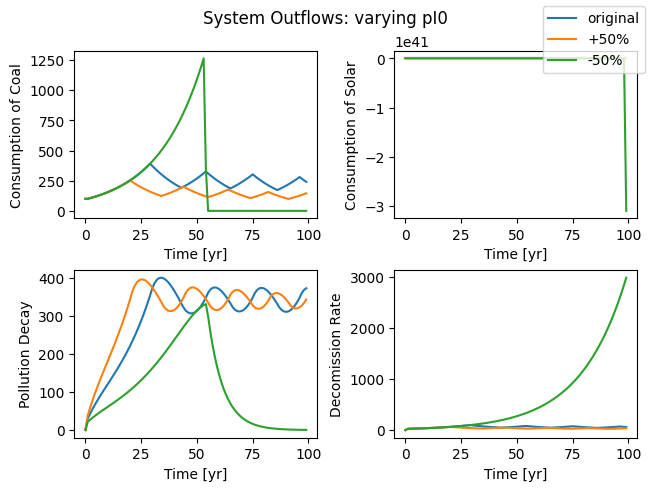

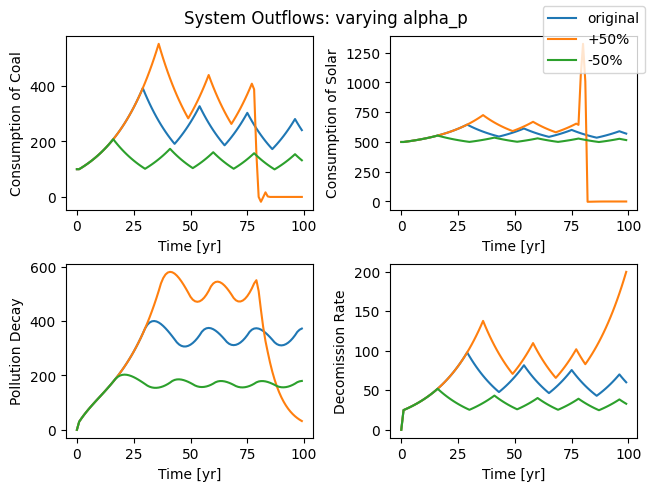

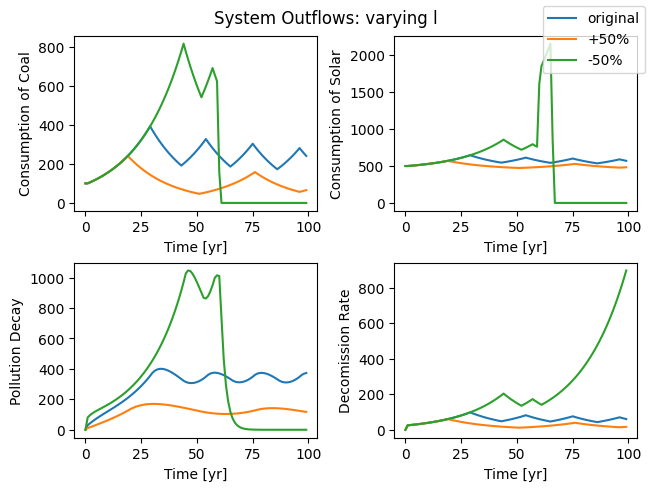

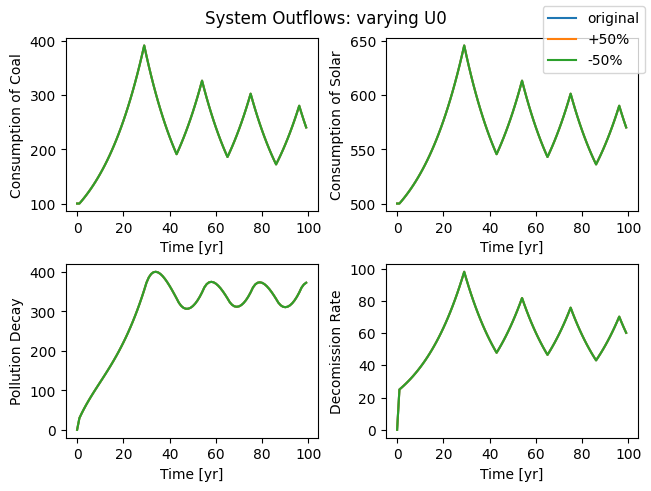

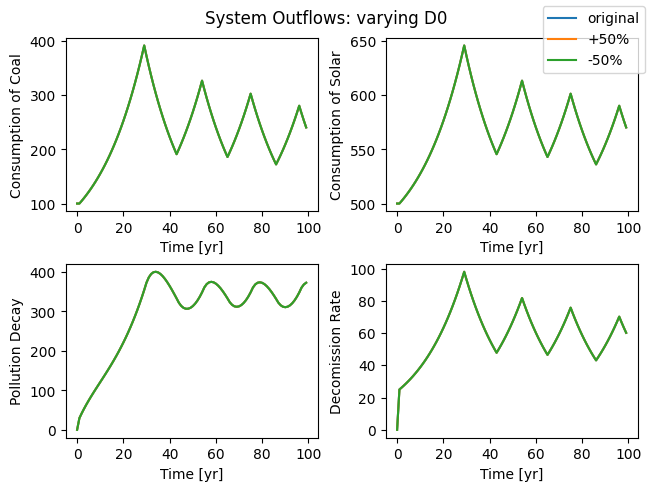

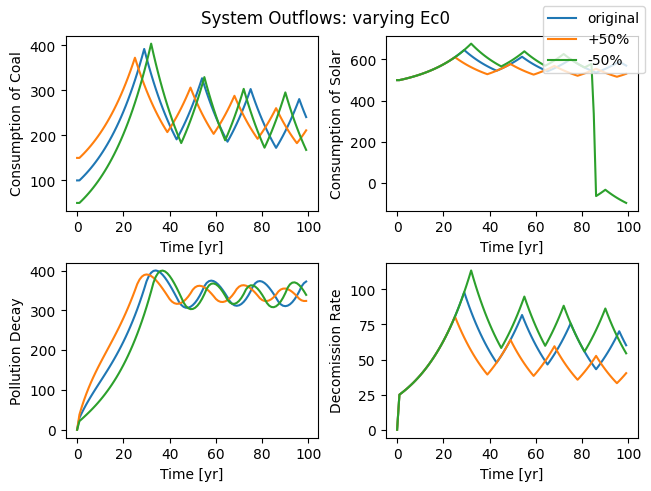

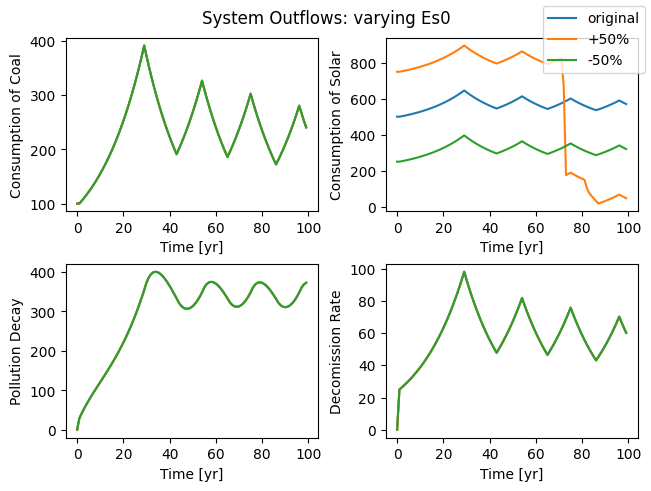

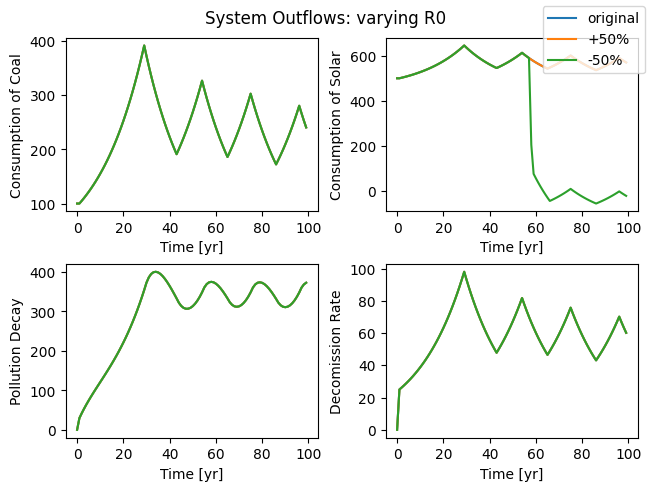

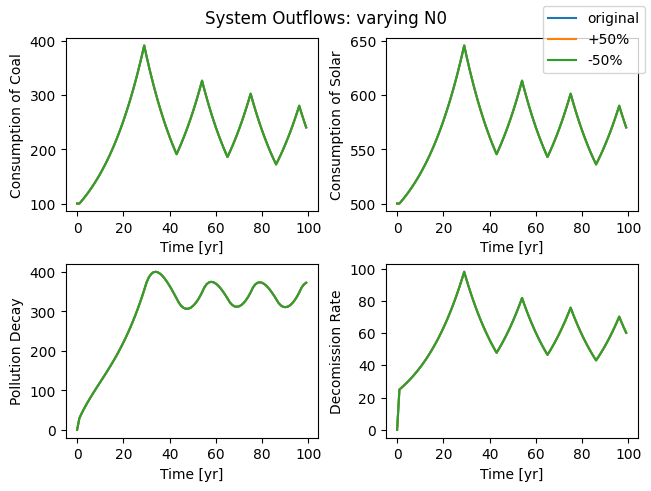

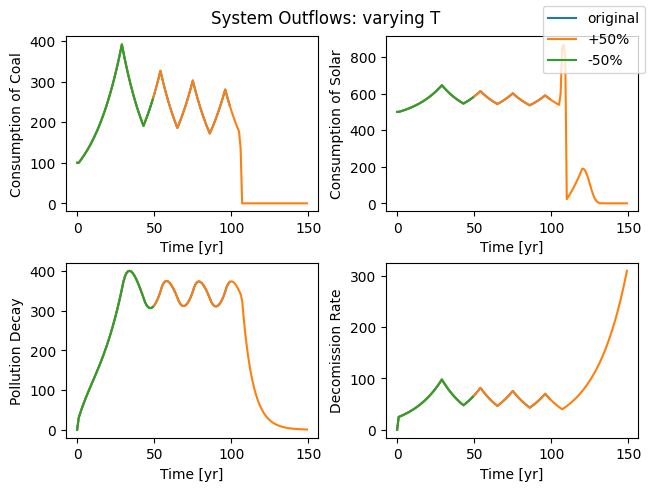

In [11]:
# run sensitivity analysis for outflows
sensitivity_analysis('outflow')

## Case Studies

In [12]:
case1 = {"p0"        : 100,
          "b0"        : 500,
          "c0"        : 25000,
          "s0"        : 5000,
          "ds_plus"   : 0.3,
          "ds_minus"  : 0.1,
          "dc_minus"  : 0.2,
          "db_plus"   : 0.08,
          "db_minus"  : 0.05,
          "pI0"       : 1.2,
          "alpha_p"   : 2500,
          "l"         : 2.,
          "U0"        : 0.,
          "D0"        : 0.,
          "Ec0"       : 100,
          "Es0"       : 500,
          "R0"        : 1500,
          "N0"        : 0.,     # Initial rate of pollution decay
          "T"         : 100,    # Number of time steps
          }


params_list = [case1]

In [13]:
results = [None]*len(params_list)
for i, params in enumerate(params_list):
      model = SystemSimulator(params, prints = False)
      model.simulate()
      results[i] = model.save_results()

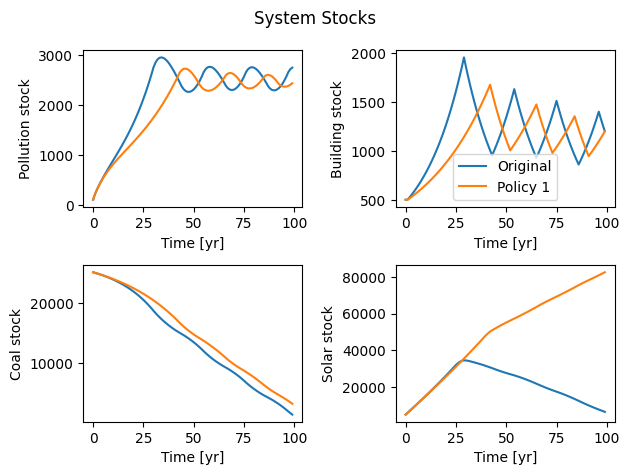

In [14]:
# plot case study stocks
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_stocks(df,ax)
  fig, ax = plot_stocks(r,ax)
ax[0,1].legend(["Original", "Policy 1"])
fig.tight_layout()

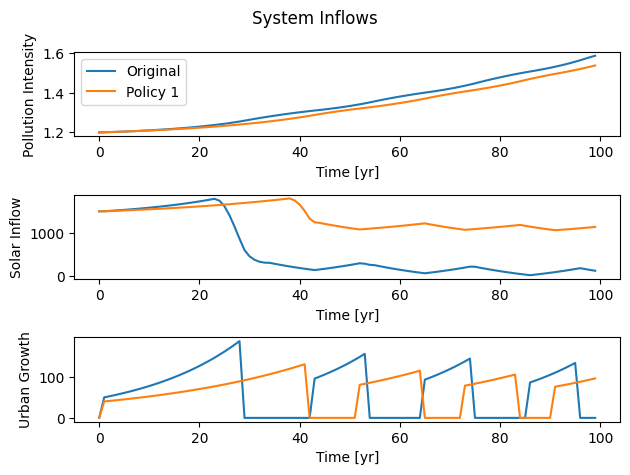

In [15]:
# plot case study inflows
fig, ax = plt.subplots(3,1)
for i,r in enumerate(results):
  fig, ax = plot_inflows(df,ax)
  fig, ax = plot_inflows(r,ax)
ax[0].legend(["Original", "Policy 1"])
fig.tight_layout()

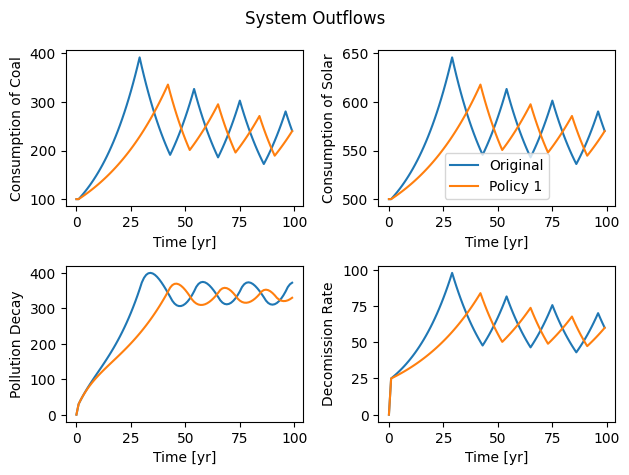

In [16]:
# plot case study outflows
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_outflows(df,ax)
  fig, ax = plot_outflows(r,ax)
ax[0,1].legend(["Original", "Policy 1"])
fig.tight_layout()

In [17]:
case2 = {"p0"        : 100,
          "b0"        : 500,
          "c0"        : 25000,
          "s0"        : 5000,
          "ds_plus"   : 0.3,
          "ds_minus"  : 0.1,
          "dc_minus"  : 0.1,
          "db_plus"   : 0.1,
          "db_minus"  : 0.05,
          "pI0"       : 1.2,
          "alpha_p"   : 2500,
          "l"         : 2.,
          "U0"        : 0.,
          "D0"        : 0.,
          "Ec0"       : 100,
          "Es0"       : 500,
          "R0"        : 1500,
          "N0"        : 0.,     # Initial rate of pollution decay
          "T"         : 100,    # Number of time steps
          }


params_list = [case2]

In [18]:
results = [None]*len(params_list)
for i, params in enumerate(params_list):
      model = SystemSimulator(params, prints = False)
      model.simulate()
      results[i] = model.save_results()

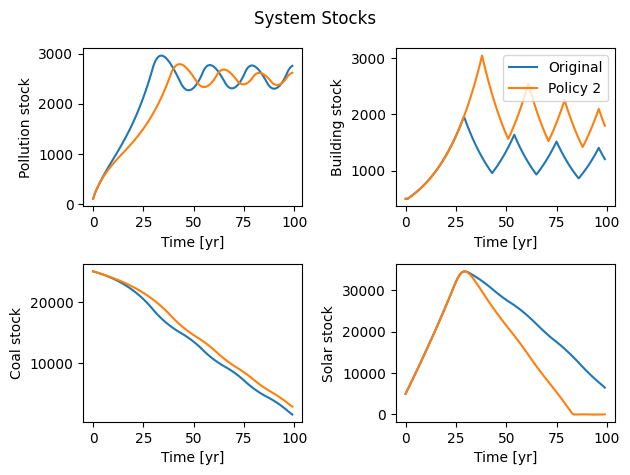

In [19]:
# plot case study stocks
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_stocks(df,ax)
  fig, ax = plot_stocks(r,ax)
ax[0,1].legend(["Original", "Policy 2"])
fig.tight_layout()

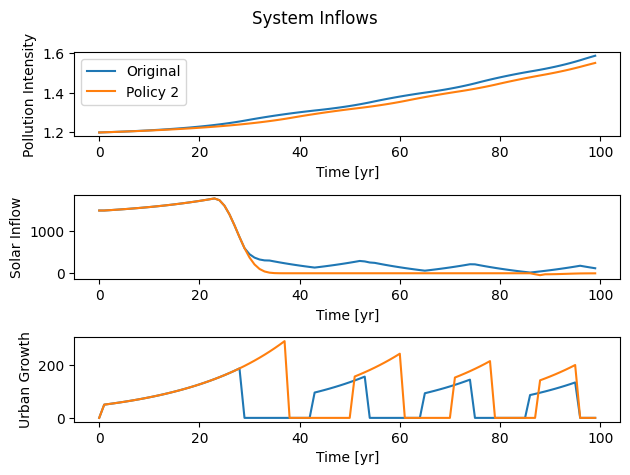

In [20]:
# plot case study inflows
fig, ax = plt.subplots(3,1)
for i,r in enumerate(results):
  fig, ax = plot_inflows(df,ax)
  fig, ax = plot_inflows(r,ax)
ax[0].legend(["Original", "Policy 2"])
fig.tight_layout()

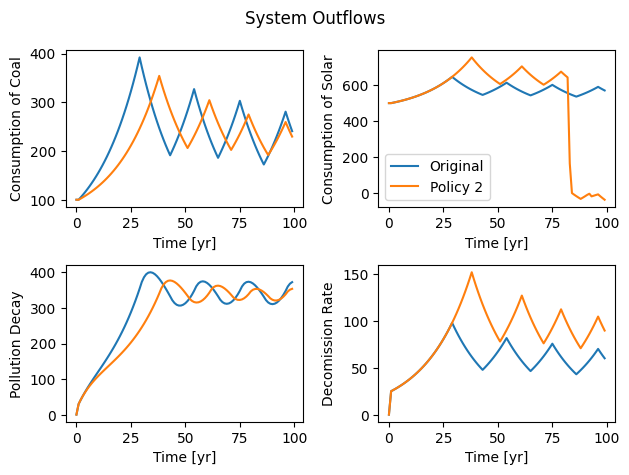

In [21]:
# plot case study outflows
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_outflows(df,ax)
  fig, ax = plot_outflows(r,ax)
ax[0,1].legend(["Original", "Policy 2"])
fig.tight_layout()

In [22]:
case3 = {"p0"        : 100,
          "b0"        : 500,
          "c0"        : 25000,
          "s0"        : 5000,
          "ds_plus"   : 0.3,
          "ds_minus"  : 0.1,
          "dc_minus"  : 0.2,
          "db_plus"   : 0.1,
          "db_minus"  : 0.05,
          "pI0"       : 1.1,
          "alpha_p"   : 2500,
          "l"         : 2.,
          "U0"        : 0.,
          "D0"        : 0.,
          "Ec0"       : 100,
          "Es0"       : 500,
          "R0"        : 1500,
          "N0"        : 0.,     # Initial rate of pollution decay
          "T"         : 100,    # Number of time steps
          }


params_list = [case3]

In [23]:
results = [None]*len(params_list)
for i, params in enumerate(params_list):
      model = SystemSimulator(params, prints = False)
      model.simulate()
      results[i] = model.save_results()

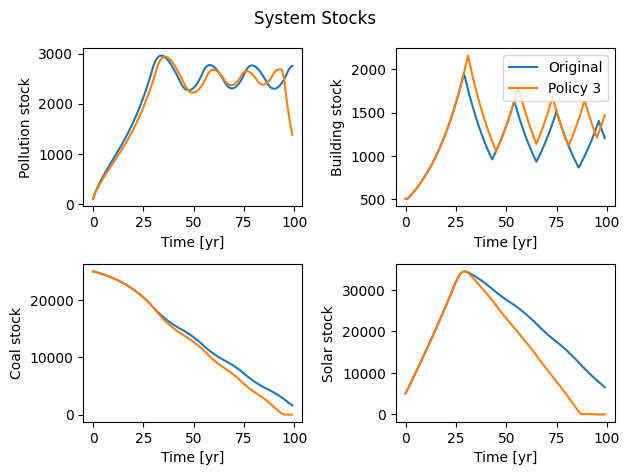

In [24]:
# plot case study stocks
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_stocks(df,ax)
  fig, ax = plot_stocks(r,ax)
ax[0,1].legend(["Original", "Policy 3"])
fig.tight_layout()

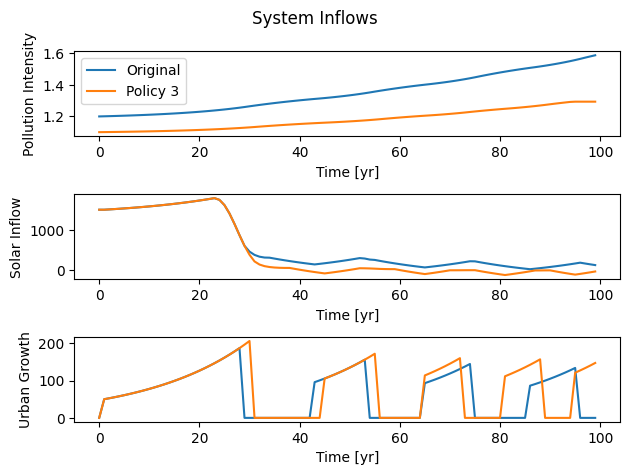

In [25]:
# plot case study inflows
fig, ax = plt.subplots(3,1)
for i,r in enumerate(results):
  fig, ax = plot_inflows(df,ax)
  fig, ax = plot_inflows(r,ax)
ax[0].legend(["Original", "Policy 3"])
fig.tight_layout()

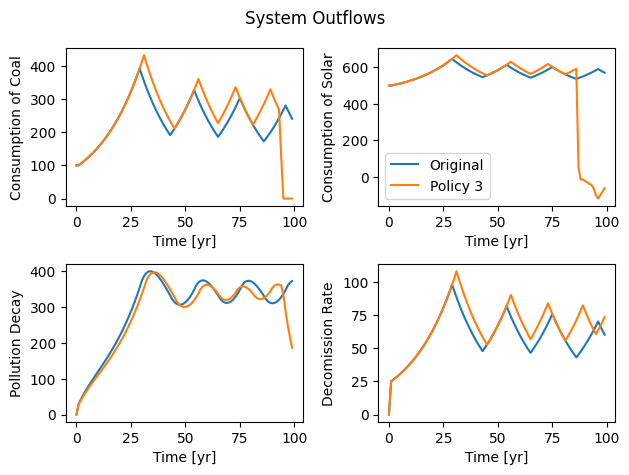

In [26]:
# plot case study outflows
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_outflows(df,ax)
  fig, ax = plot_outflows(r,ax)
ax[0,1].legend(["Original", "Policy 3"])
fig.tight_layout()

In [27]:
case_aggregate = {"p0"        : 100,
          "b0"        : 500,
          "c0"        : 25000,
          "s0"        : 5000,
          "ds_plus"   : 0.3,
          "ds_minus"  : 0.1,
          "dc_minus"  : 0.1,
          "db_plus"   : 0.08,
          "db_minus"  : 0.05,
          "pI0"       : 1.1,
          "alpha_p"   : 2500,
          "l"         : 2.,
          "U0"        : 0.,
          "D0"        : 0.,
          "Ec0"       : 100,
          "Es0"       : 500,
          "R0"        : 1500,
          "N0"        : 0.,     # Initial rate of pollution decay
          "T"         : 100,    # Number of time steps
          }


params_list = [case_aggregate]

In [28]:
results = [None]*len(params_list)
for i, params in enumerate(params_list):
      model = SystemSimulator(params, prints = False)
      model.simulate()
      results[i] = model.save_results()

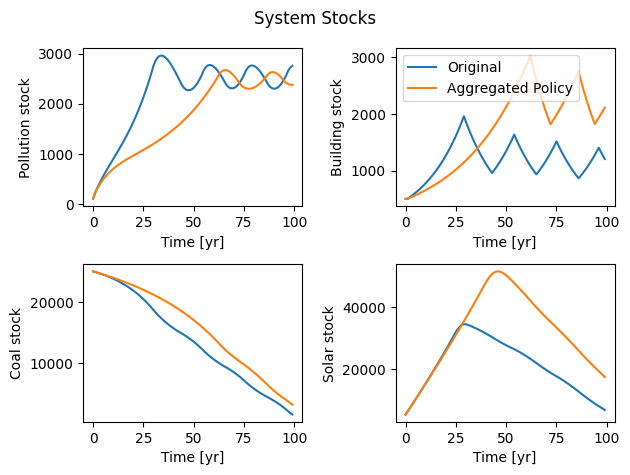

In [29]:
# plot case study stocks
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_stocks(df,ax)
  fig, ax = plot_stocks(r,ax)
ax[0,1].legend(["Original", "Aggregated Policy"])
fig.tight_layout()

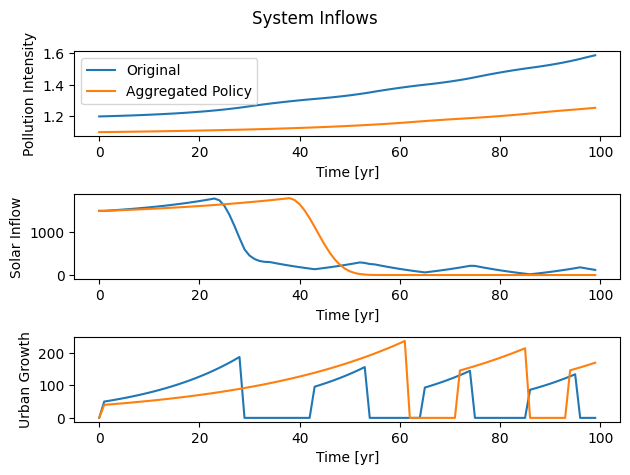

In [30]:
# plot case study inflows
fig, ax = plt.subplots(3,1)
for i,r in enumerate(results):
  fig, ax = plot_inflows(df,ax)
  fig, ax = plot_inflows(r,ax)
ax[0].legend(["Original", "Aggregated Policy"])
fig.tight_layout()

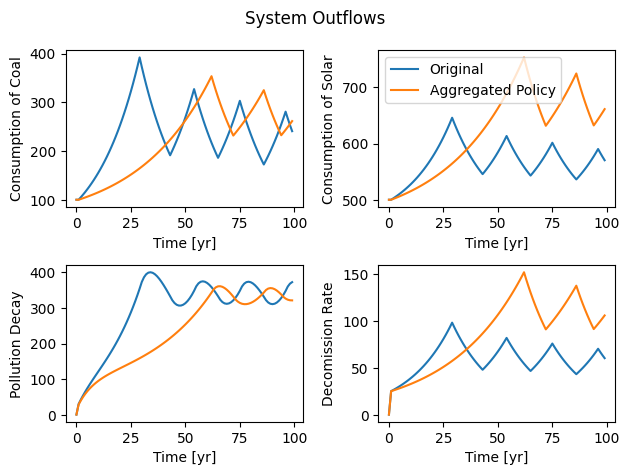

In [31]:
# plot case study outflows
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_outflows(df,ax)
  fig, ax = plot_outflows(r,ax)
ax[0,1].legend(["Original", "Aggregated Policy"])
fig.tight_layout()

In [32]:
case_test = {"p0"        : 100,
          "b0"        : 500,
          "c0"        : 25000,
          "s0"        : 5000,
          "ds_plus"   : 0.3,
          "ds_minus"  : 0.1,
          "dc_minus"  : 0.2,
          "db_plus"   : 0.08,
          "db_minus"  : 0.05,
          "pI0"       : 1.2,
          "alpha_p"   : 2500,
          "l"         : 3.,
          "U0"        : 0.,
          "D0"        : 0.,
          "Ec0"       : 100,
          "Es0"       : 500,
          "R0"        : 1500,
          "N0"        : 0.,     # Initial rate of pollution decay
          "T"         : 100,    # Number of time steps
          }


params_list = [case_test]

In [33]:
results = [None]*len(params_list)
for i, params in enumerate(params_list):
      model = SystemSimulator(params, prints = False)
      model.simulate()
      results[i] = model.save_results()

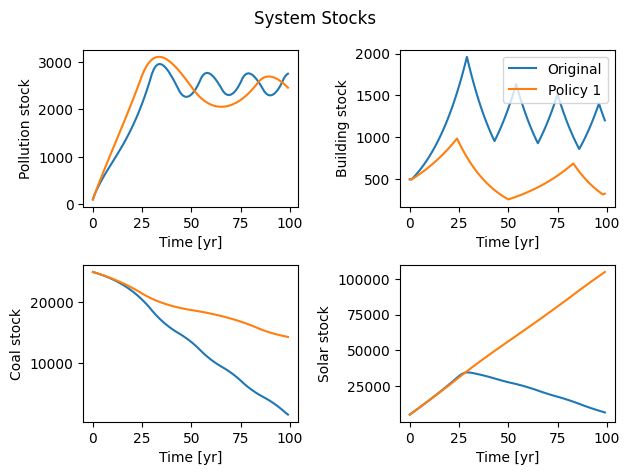

In [34]:
# plot case study stocks
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_stocks(df,ax)
  fig, ax = plot_stocks(r,ax)
ax[0,1].legend(["Original", "Policy 1"])
fig.tight_layout()

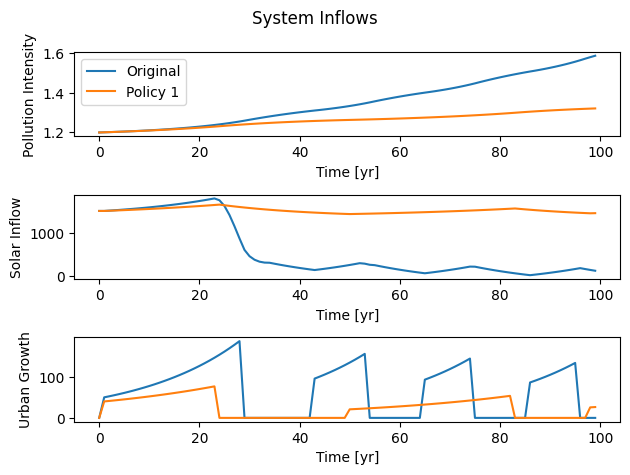

In [35]:
# plot case study inflows
fig, ax = plt.subplots(3,1)
for i,r in enumerate(results):
  fig, ax = plot_inflows(df,ax)
  fig, ax = plot_inflows(r,ax)
ax[0].legend(["Original", "Policy 1"])
fig.tight_layout()

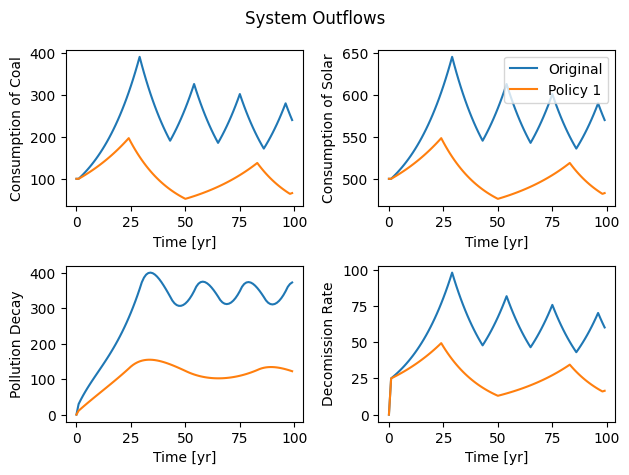

In [36]:
# plot case study outflows
fig, ax = plt.subplots(2,2)
for i,r in enumerate(results):
  fig, ax = plot_outflows(df,ax)
  fig, ax = plot_outflows(r,ax)
ax[0,1].legend(["Original", "Policy 1"])
fig.tight_layout()